In [ ]:
#Test molecules 

#Acetophenone: 
CC(=O)c1ccccc1
#Benzyl alcohol:
CC(C1=CC=CC=C1)O


📋 Top 50 Predicted Templates & Reactants:

🔹 Rank 1
TemplateHash: e913b1094150d416bf8203e6e8c96f70bb606ea82d757cc0bdffcc4e7fad5f5a
Model Probability: 26.28%
SMARTS: [C:2]-[CH2;D2;+0:1]-[O;H0;D2;+0:5]-[C:4]=[O;D1;H0:3]>>O-[CH2;D2;+0:1]-[C:2].[O;D1;H0:3]=[C:4]-[OH;D1;+0:5]


[20:41:55] DEPRECATION WARNING: please use MorganGenerator


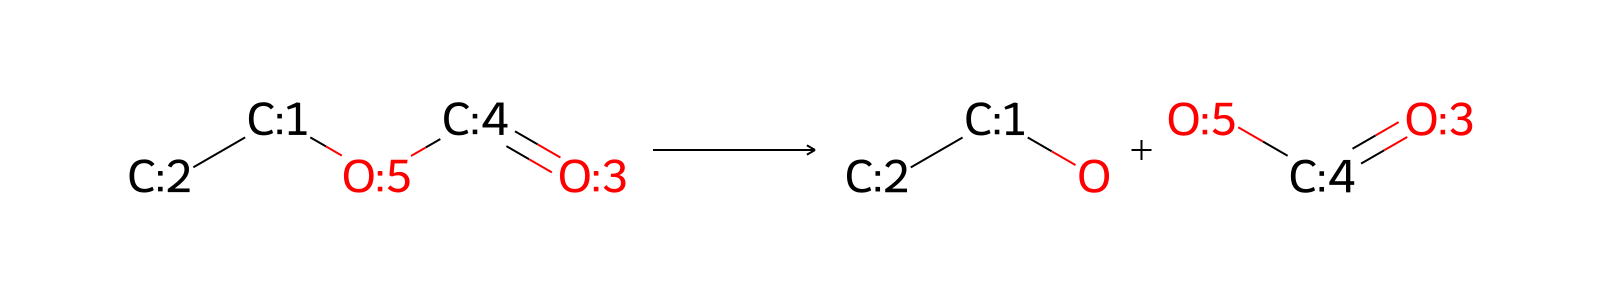

❗ No valid reactants generated.

🔹 Rank 2
TemplateHash: d6cd4b654ea9c0c70f46370e1cee31e9c9f3d14fe48630567825239597a9c0f6
Model Probability: 16.82%
SMARTS: [#7;a:2]:[c;H0;D3;+0:1](-[O;H0;D2;+0:8]-[C:7]):[c:3]-[C:4](=[O;D1;H0:5])-[O;D1;H1:6]>>Cl-[c;H0;D3;+0:1](:[#7;a:2]):[c:3]-[C:4](=[O;D1;H0:5])-[O;D1;H1:6].[C:7]-[OH;D1;+0:8]


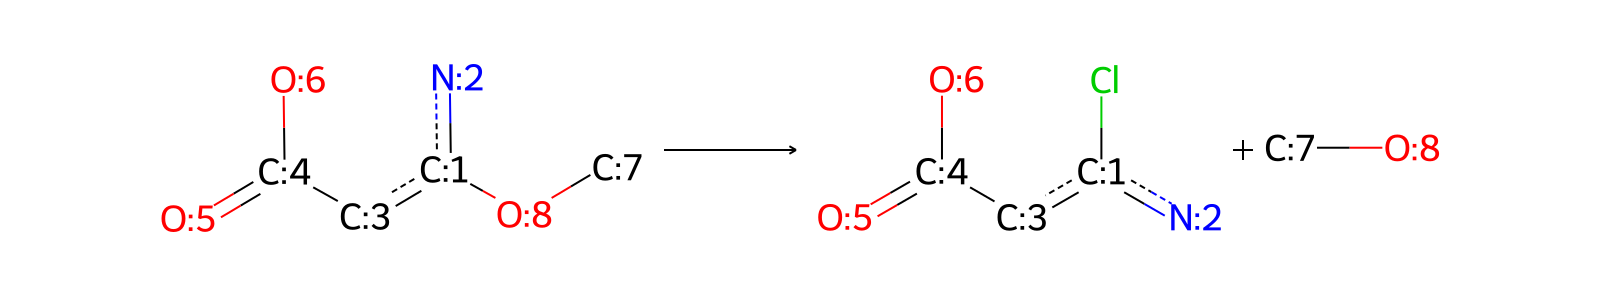

❗ No valid reactants generated.

🔹 Rank 3
TemplateHash: be3d30ad1fc2b6a0a5ed18b61d936cf2f204d0794e3e0ff84eb61aba73586c14
Model Probability: 10.43%
SMARTS: [C:4]-[O;H0;D2;+0:5]-[c;H0;D3;+0:1](:[c:2]):[c:3]>>Cl-[c;H0;D3;+0:1](:[c:2]):[c:3].[C:4]-[OH;D1;+0:5]


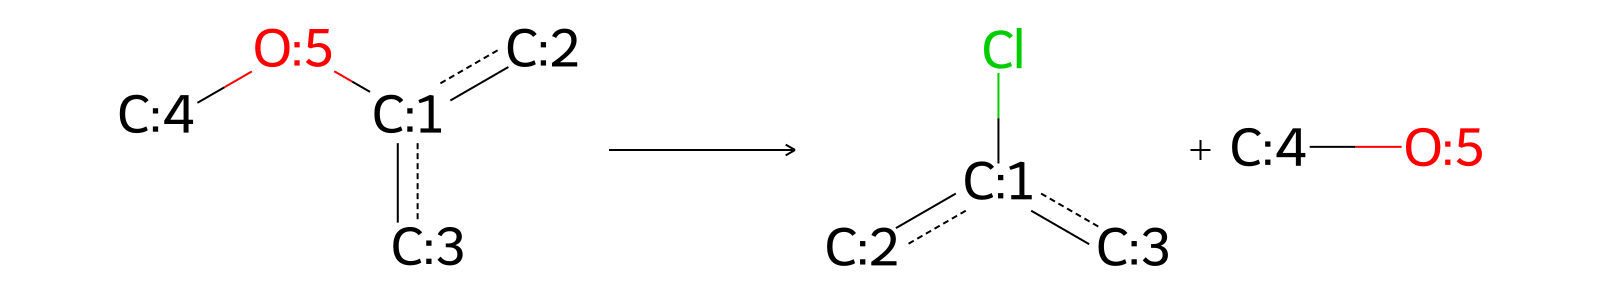

❗ No valid reactants generated.

🔹 Rank 4
TemplateHash: 2594708995270befc501d889efee0eae44fa9857125ab9bb094fc9116551ebc7
Model Probability: 8.14%
SMARTS: [C:2]-[CH2;D2;+0:1]-[NH;D2;+0:3]-[c:4]>>O-[CH2;D2;+0:1]-[C:2].[NH2;D1;+0:3]-[c:4]


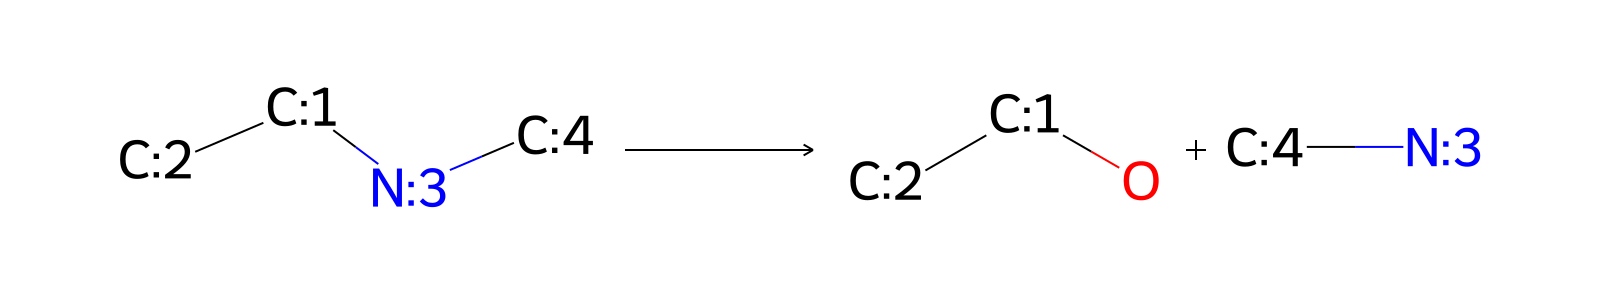

❗ No valid reactants generated.

🔹 Rank 5
TemplateHash: 262c4c293d2443c91a98ac4c4d1dcdeecb5a6ed8e110657fa89cdbb99a596760
Model Probability: 7.59%
SMARTS: [#7:9]-[C:8](=[O;D1;H0:10])-[c:7]1:[c:6]:[c:5]:[c:4]:[c:3](-[C;H0;D3;+0:1](=[O;D1;H0:2])-[O;H0;D2;+0:13]-[C:12]):[c:11]:1>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]1:[c:4]:[c:5]:[c:6]:[c:7](-[C:8](-[#7:9])=[O;D1;H0:10]):[c:11]:1.[C:12]-[OH;D1;+0:13]


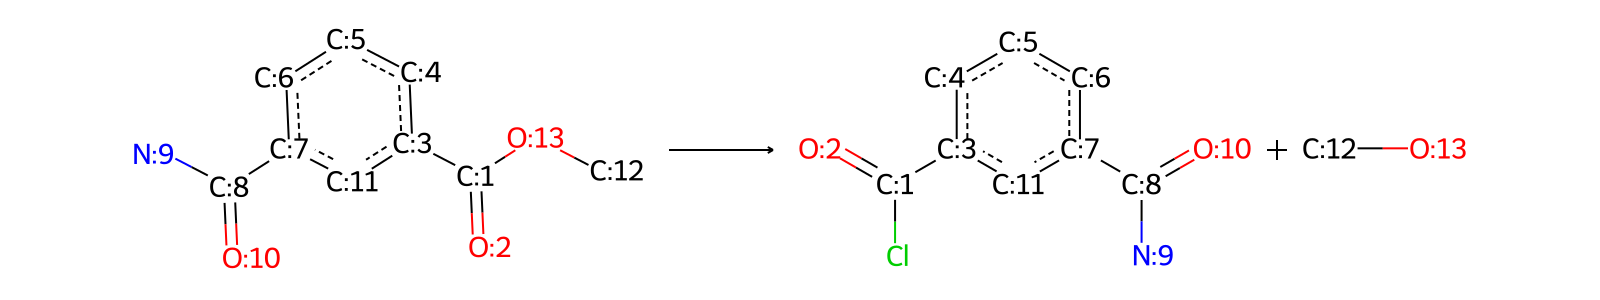

❗ No valid reactants generated.

🔹 Rank 6
TemplateHash: 73ef67ba9051c1f66d1cf85b72c020a6342343e5cdb9c1cec837377638dfdccf
Model Probability: 6.85%
SMARTS: [C:4]-[O;H0;D2;+0:5]-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[C:4]-[OH;D1;+0:5]


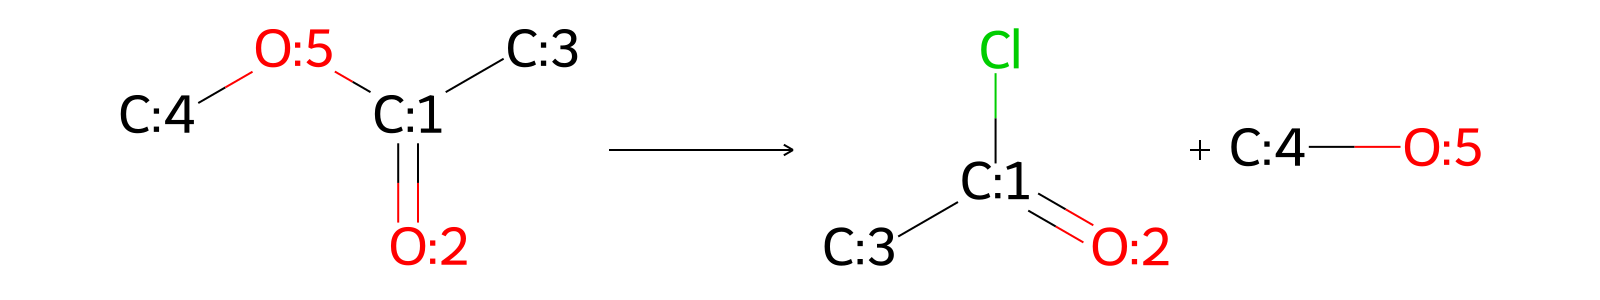

❗ No valid reactants generated.

🔹 Rank 7
TemplateHash: 710688da64dad8b4bbb1429a820e16ee10930f14ebeddd0b23367c63178b82fb
Model Probability: 3.43%
SMARTS: [C:3]=[C:4]-[C:5](=[O;D1;H0:6])-[O;H0;D2;+0:7]-[CH2;D2;+0:1]-[C;D1;H3:2]>>O-[CH2;D2;+0:1]-[C;D1;H3:2].[C:3]=[C:4]-[C:5](=[O;D1;H0:6])-[OH;D1;+0:7]


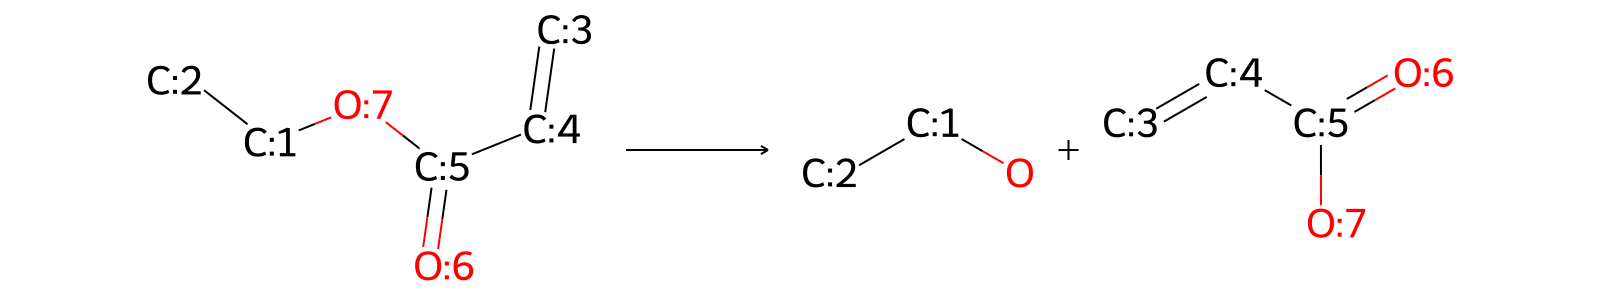

❗ No valid reactants generated.

🔹 Rank 8
TemplateHash: 695b4da109804322de1755d4f5d470ffaa04aa08894765b3bd0ddcc42630f20b
Model Probability: 2.36%
SMARTS: [O;D1;H0:2]=[C;H0;D3;+0:1](-[c:3])-[c;H0;D3;+0:5](:[c:4]):[c:6]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3].[c:4]:[cH;D2;+0:5]:[c:6]


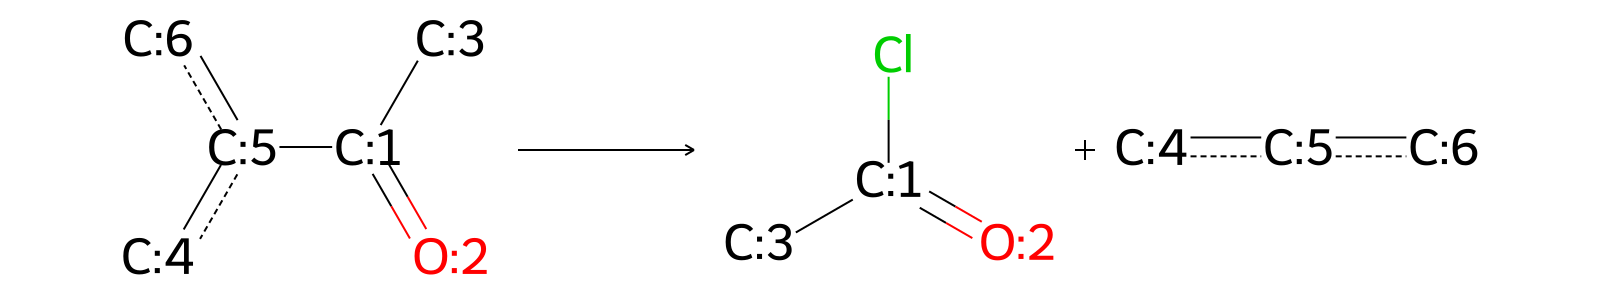

❗ No valid reactants generated.

🔹 Rank 9
TemplateHash: 50e43838e8700604f5bc75521befefac756afe237ba1b1ed0e956410b3f7da27
Model Probability: 1.91%
SMARTS: [C:2]-[CH2;D2;+0:1]-[O;H0;D2;+0:3]-[c:4]>>O-[CH2;D2;+0:1]-[C:2].[OH;D1;+0:3]-[c:4]


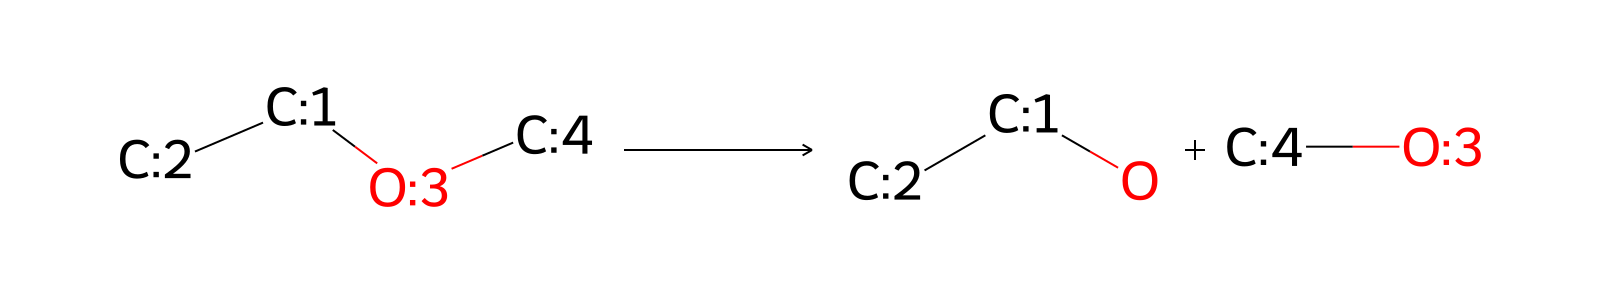

❗ No valid reactants generated.

🔹 Rank 10
TemplateHash: 2cde0dcf08a184cfd07545c7d186ce1c5af318c28be21626ebd0fbbe4b6e3e7f
Model Probability: 1.82%
SMARTS: [C:4]-[O;H0;D2;+0:5]-[c;H0;D3;+0:1](:[c:2]):[c:3]>>F-[c;H0;D3;+0:1](:[c:2]):[c:3].[C:4]-[OH;D1;+0:5]


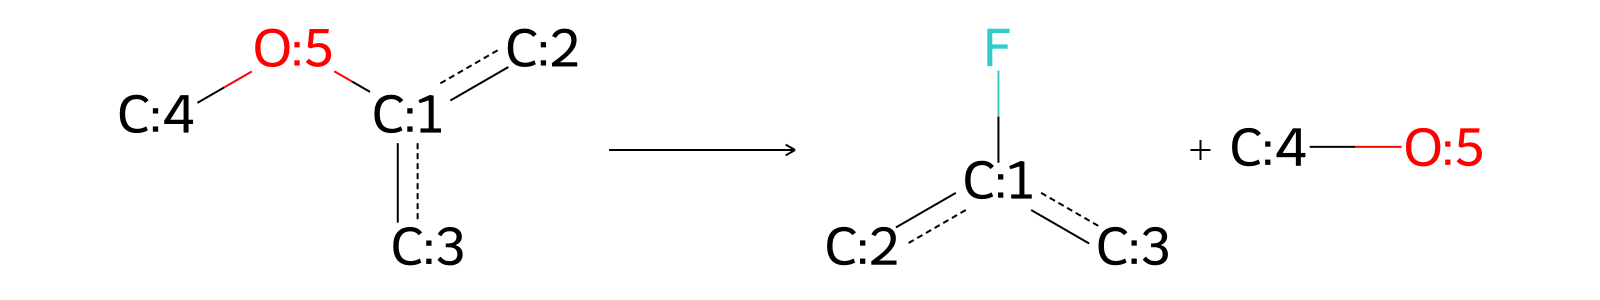

❗ No valid reactants generated.

🔹 Rank 11
TemplateHash: fa0d851e142c3b477b32521aea18d9f060fb648ef723206a28e37b25b71593bd
Model Probability: 1.42%
SMARTS: [C:2]-[CH2;D2;+0:1]-[OH;D1;+0:3]>>C-O-[C;H0;D3;+0:1](-[C:2])=[O;H0;D1;+0:3]


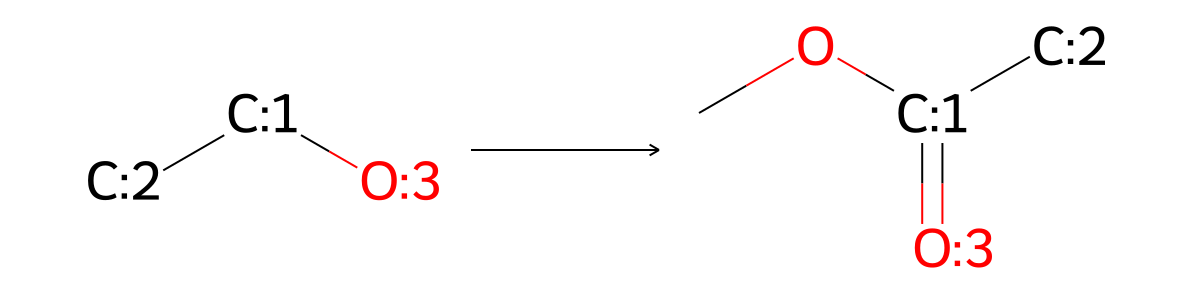

Predicted Reactants:
   ['CCCC(=O)OC']

🔹 Rank 12
TemplateHash: 70386c466b4a84c439f157a77fa4211b29e94313cc9e1a22beb1c41f8369da1d
Model Probability: 0.98%
SMARTS: [C:3]-[O;H0;D2;+0:4]-[CH2;D2;+0:1]-[c:2]>>Br-[CH2;D2;+0:1]-[c:2].[C:3]-[OH;D1;+0:4]


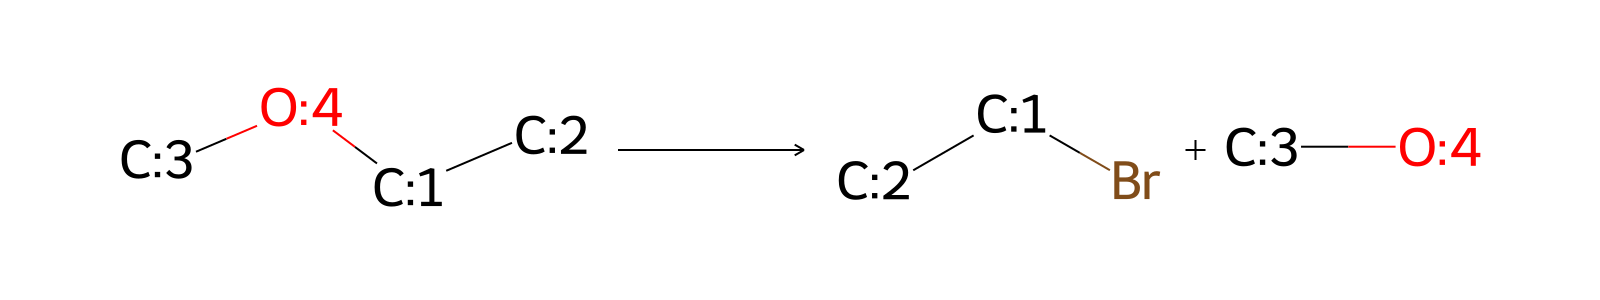

❗ No valid reactants generated.

🔹 Rank 13
TemplateHash: 1d472fc1f3a52c8b025872bf53c09d10016a790c0a0274b2900413770685fa3f
Model Probability: 0.94%
SMARTS: [C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](=[O;D1;H0:2])(=[O;D1;H0:3])-[c:4]>>Cl-[S;H0;D4;+0:1](=[O;D1;H0:2])(=[O;D1;H0:3])-[c:4].[C:5]-[OH;D1;+0:6]


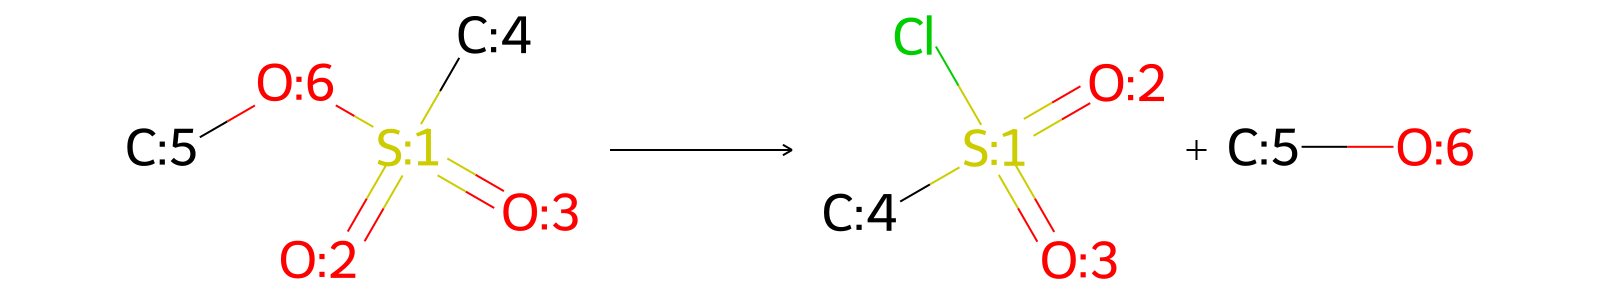

❗ No valid reactants generated.

🔹 Rank 14
TemplateHash: a1727cc9ed68a6411bfd02873c1615c22baa1af4957f14ae942e2c85caf9adb5
Model Probability: 0.60%
SMARTS: [C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](-[C;D1;H3:2])(=[O;D1;H0:3])=[O;D1;H0:4]>>Cl-[S;H0;D4;+0:1](-[C;D1;H3:2])(=[O;D1;H0:3])=[O;D1;H0:4].[C:5]-[OH;D1;+0:6]


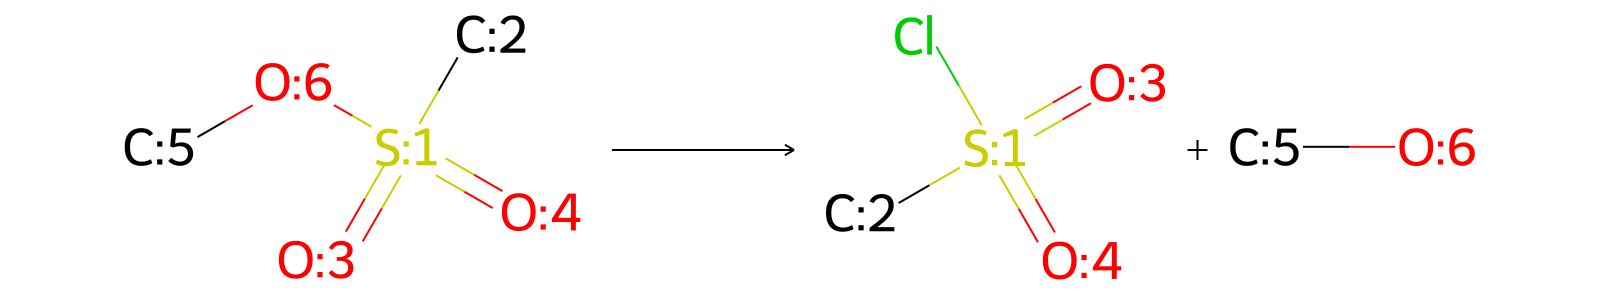

❗ No valid reactants generated.

🔹 Rank 15
TemplateHash: afb6b57893cb8cbfd28b11cc07093a4c632771397713f8b0cb95878100da599b
Model Probability: 0.58%
SMARTS: [#7;a:2]:[c;H0;D3;+0:1](:[#7;a:3])-[O;H0;D2;+0:5]-[C;D1;H3:4]>>Cl-[c;H0;D3;+0:1](:[#7;a:2]):[#7;a:3].[C;D1;H3:4]-[OH;D1;+0:5]


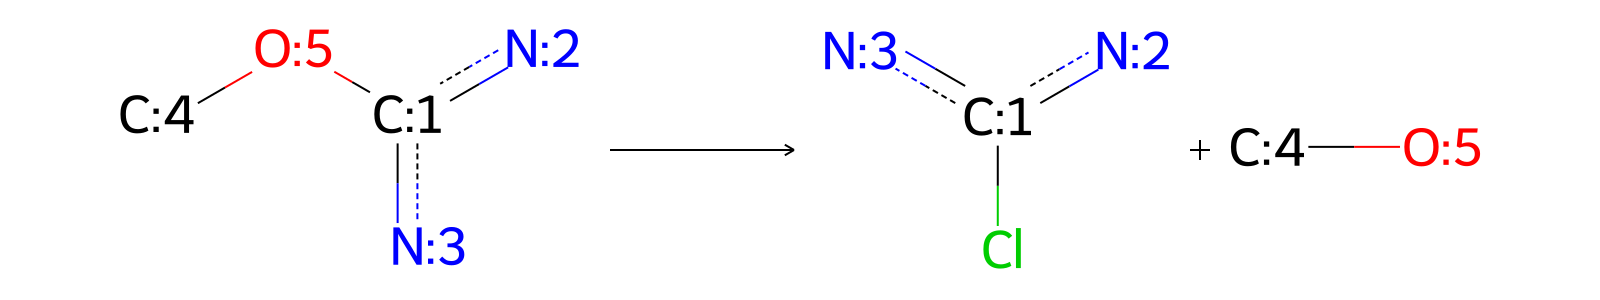

❗ No valid reactants generated.

🔹 Rank 16
TemplateHash: 1f38c73dd1efbc6bf016cb942ae5b215f30229cf64fe95882f5ea6326e5ce2a5
Model Probability: 0.50%
SMARTS: [C:4]-[N;H0;D3;+0:5](-[C:6])-[c;H0;D3;+0:1](:[c:2]):[c:3]>>Cl-[c;H0;D3;+0:1](:[c:2]):[c:3].[C:4]-[NH;D2;+0:5]-[C:6]


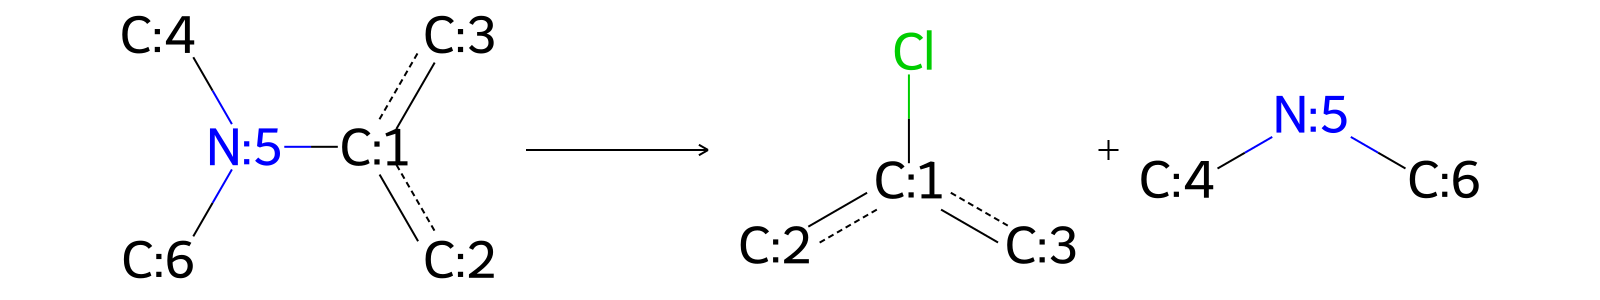

❗ No valid reactants generated.

🔹 Rank 17
TemplateHash: 1771a25b37ab787bf45a45bc0ae4f1bf2e15c9c90d1a67de45352835087e3c5b
Model Probability: 0.45%
SMARTS: [C:2]-[CH2;D2;+0:1]-[O;H0;D2;+0:10]-[c:9]1:[c:8]:[c:7](-[C:5](=[O;D1;H0:6])-[#8:4]-[C;D1;H3:3]):[c:13]:[c:12]:[c:11]:1>>O-[CH2;D2;+0:1]-[C:2].[C;D1;H3:3]-[#8:4]-[C:5](=[O;D1;H0:6])-[c:7]1:[c:8]:[c:9](-[OH;D1;+0:10]):[c:11]:[c:12]:[c:13]:1


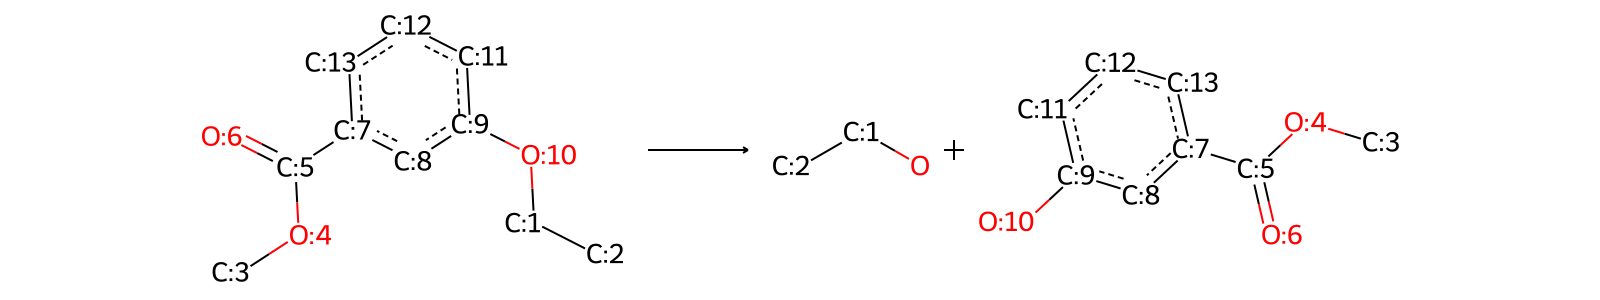

❗ No valid reactants generated.

🔹 Rank 18
TemplateHash: 8e114932fc6bf59d5b0fdbf123759336758db54652e2df40402b5d597907bf3a
Model Probability: 0.44%
SMARTS: [C;H0;D4;+0:5]1-[O;H0;D2;+0:6]-[CH2;D2;+0:1]-[CH2;D2;+0:2]-[CH2;D2;+0:3]-[O;H0;D2;+0:4]-1>>O-[CH2;D2;+0:1]-[CH2;D2;+0:2]-[CH2;D2;+0:3]-[OH;D1;+0:4].[C;H0;D3;+0:5]=[O;H0;D1;+0:6]


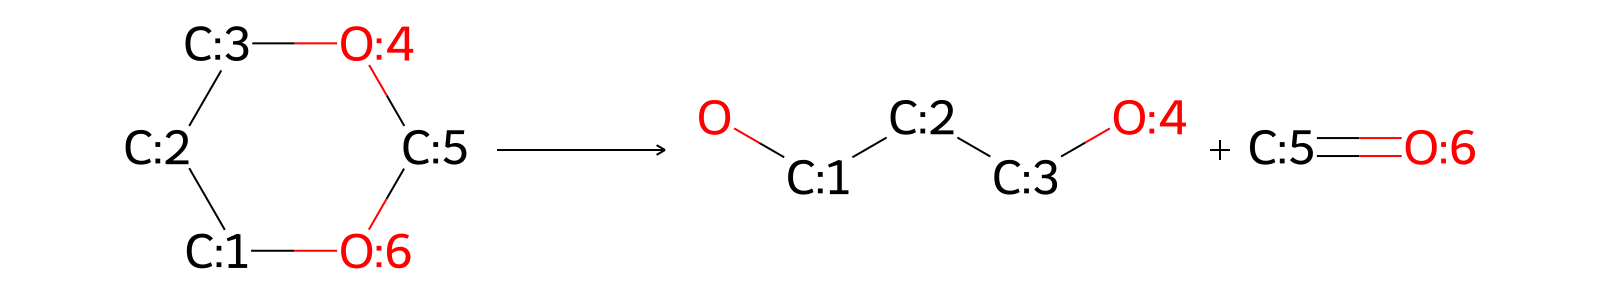

❗ No valid reactants generated.

🔹 Rank 19
TemplateHash: e580421d9eeed18d38a6ce4d7b5d59df8fa1662ab4d400650ffe0d2231826db2
Model Probability: 0.44%
SMARTS: [C:2]-[CH2;D2;+0:1]-[O;H0;D2;+0:4]-[C:3]>>C-S(=O)(=O)-O-[CH2;D2;+0:1]-[C:2].[C:3]-[OH;D1;+0:4]


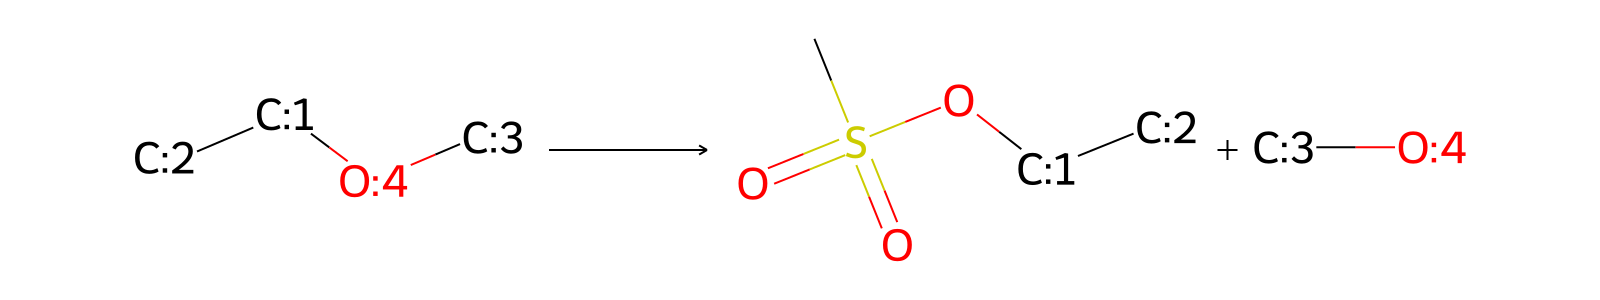

❗ No valid reactants generated.

🔹 Rank 20
TemplateHash: ef2ab959b5f43c389ca1cf17bc917f8dca962df418b995be5d3e482d7860e883
Model Probability: 0.37%
SMARTS: [C:2]-[O;H0;D2;+0:3]-[CH3;D1;+0:1]>>I-[CH3;D1;+0:1].[C:2]-[OH;D1;+0:3]


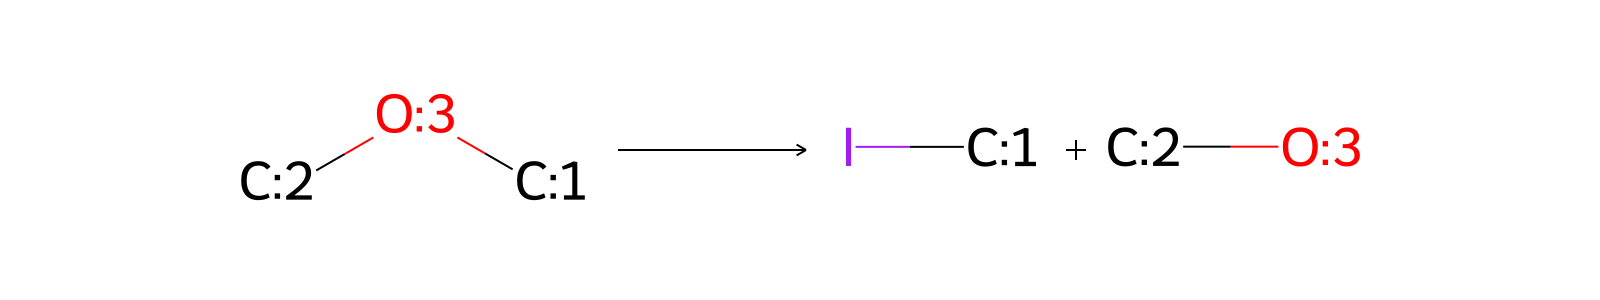

❗ No valid reactants generated.

🔹 Rank 21
TemplateHash: 5334d351a1631f3f398b85d6f34ed42258947d888ad36e82980e470da0f734d1
Model Probability: 0.33%
SMARTS: [C:3]-[N+;H0;D4:4](-[C:5])(-[C:6])-[CH2;D2;+0:1]-[c:2]>>Br-[CH2;D2;+0:1]-[c:2].[C:3]-[N;H0;D3;+0:4](-[C:5])-[C:6]


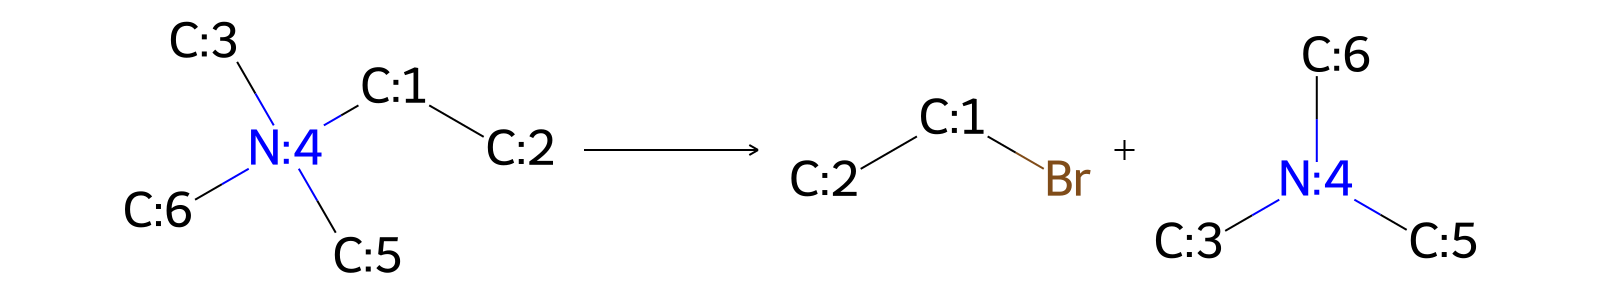

❗ No valid reactants generated.

🔹 Rank 22
TemplateHash: 8f796ad716ac38c52613baa5e87bd1bc14dbb954be0a8a6cad04cc13f35b62a7
Model Probability: 0.32%
SMARTS: [C:3]-[O;H0;D2;+0:4]-[CH2;D2;+0:1]-[c:2]>>Cl-[CH2;D2;+0:1]-[c:2].[C:3]-[OH;D1;+0:4]


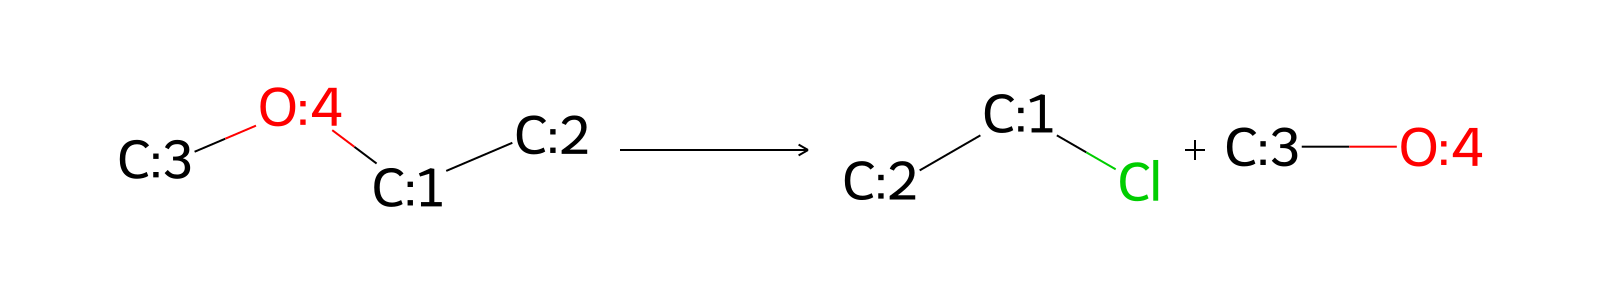

❗ No valid reactants generated.

🔹 Rank 23
TemplateHash: 06a4cb980becf3f42542f8f22eefafa0e4d03368d3db4c200814610888bd4a9d
Model Probability: 0.31%
SMARTS: [#7;a:2]:[c;H0;D3;+0:1](:[c:3])-[O;H0;D2;+0:5]-[C:4]>>Br-[c;H0;D3;+0:1](:[#7;a:2]):[c:3].[C:4]-[OH;D1;+0:5]


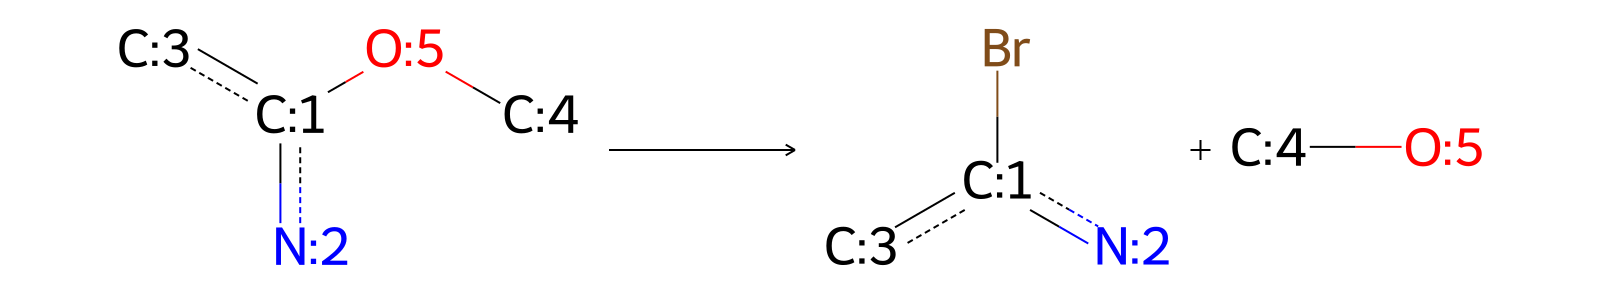

❗ No valid reactants generated.

🔹 Rank 24
TemplateHash: edd1b141cda787e2003481817ec2c717ab77191f2feb145dcf9995223201631f
Model Probability: 0.30%
SMARTS: [#7;a:2]:[c;H0;D3;+0:1](-[O;H0;D2;+0:6]-[C;D1;H3:5]):[c:3]:[#7;a:4]>>Cl-[c;H0;D3;+0:1](:[#7;a:2]):[c:3]:[#7;a:4].[C;D1;H3:5]-[OH;D1;+0:6]


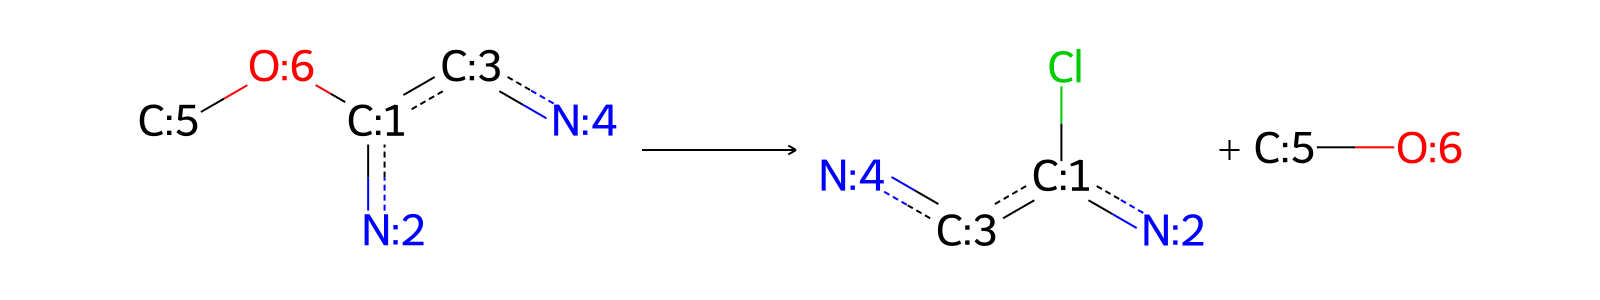

❗ No valid reactants generated.

🔹 Rank 25
TemplateHash: a7cddead5dec9b7221e2848b8b00d5c727595f422f7f9dbffc235fe4a4928d50
Model Probability: 0.30%
SMARTS: [C:2]-[CH2;D2;+0:1]-[O;H0;D2;+0:4]-[C:3]>>Cl-[CH2;D2;+0:1]-[C:2].[C:3]-[OH;D1;+0:4]


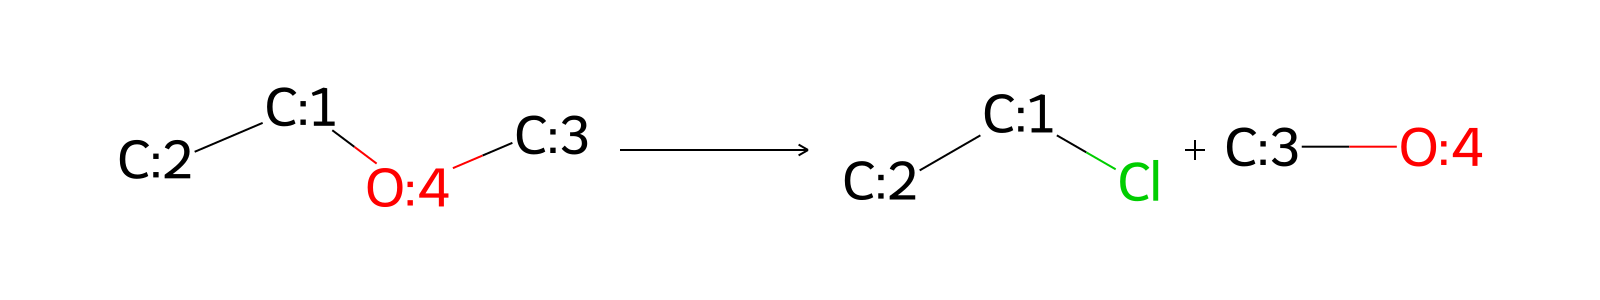

❗ No valid reactants generated.

🔹 Rank 26
TemplateHash: 9b42631ad9c994a69574b0617f3f33558ce595f9c1106184dcc1c4c66c9528e5
Model Probability: 0.27%
SMARTS: [C:4]-[O;H0;D2;+0:5]-[CH;D3;+0:1](-[C:2])-[c:3]>>Cl-[CH;D3;+0:1](-[C:2])-[c:3].[C:4]-[OH;D1;+0:5]


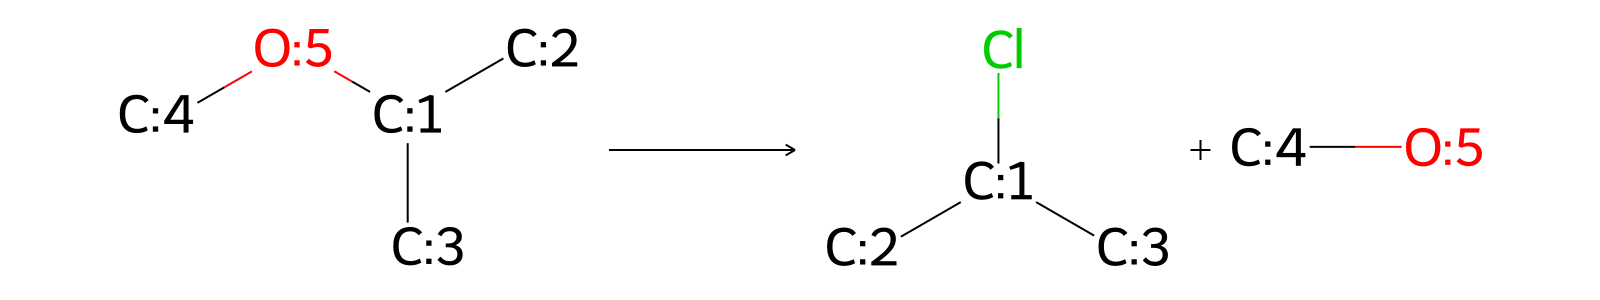

❗ No valid reactants generated.

🔹 Rank 27
TemplateHash: 98a7b7eb9d98f5552752c4af6770cd6c0000b6561a900bf1134eb417751a3724
Model Probability: 0.24%
SMARTS: [#7;a:2]:[c;H0;D3;+0:1](:[c:3])-[O;H0;D2;+0:5]-[C:4]>>Cl-[c;H0;D3;+0:1](:[#7;a:2]):[c:3].[C:4]-[OH;D1;+0:5]


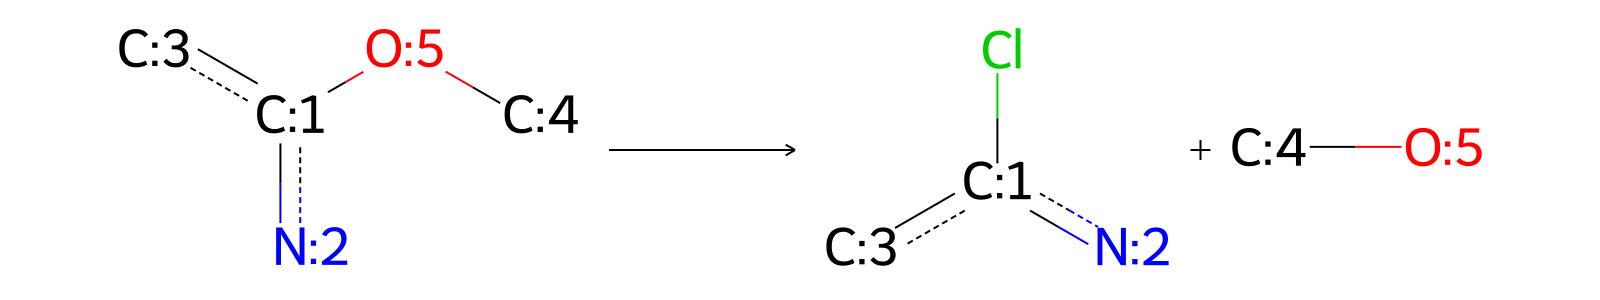

❗ No valid reactants generated.

🔹 Rank 28
TemplateHash: 9b50413c0721fc90397516b35acb0087dde817cc253ea6cbd7c364e3dd0ba0cc
Model Probability: 0.21%
SMARTS: [C:7]-[O;H0;D2;+0:8]-[c;H0;D3;+0:1]1:[#7;a:2]:[c:3]:[#7;a;+:4]:[c:5]:[c:6]:1>>Cl-[c;H0;D3;+0:1]1:[#7;a:2]:[c:3]:[#7;a;+:4]:[c:5]:[c:6]:1.[C:7]-[OH;D1;+0:8]


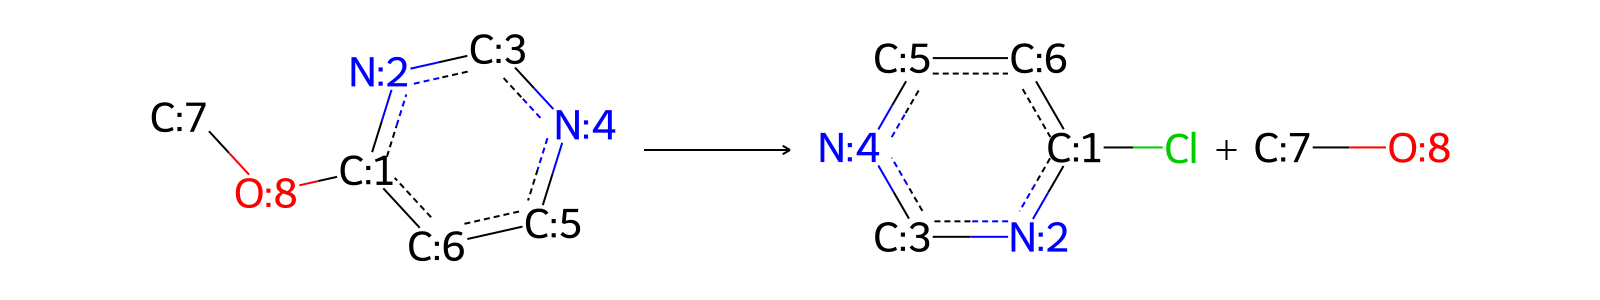

❗ No valid reactants generated.

🔹 Rank 29
TemplateHash: 95aacef1a3907ae9dbe8a9b2e75cc25ac1754cff8e9cea161cd3b1582a010f66
Model Probability: 0.20%
SMARTS: [#7;a:5]:[c:4]:[c:3]-[C;H0;D3;+0:1](=[O;D1;H0:2])-[O;H0;D2;+0:7]-[C;D1;H3:6]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]:[c:4]:[#7;a:5].[C;D1;H3:6]-[OH;D1;+0:7]


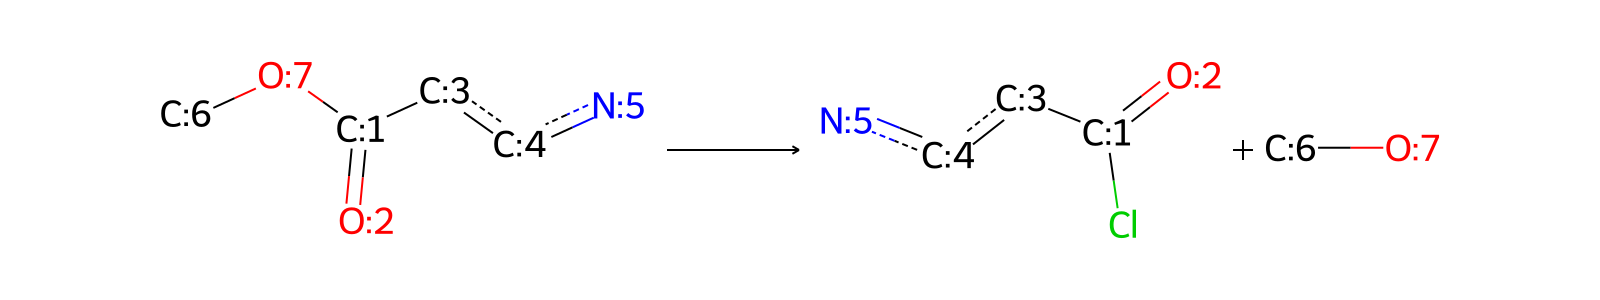

❗ No valid reactants generated.

🔹 Rank 30
TemplateHash: 8358f2c12293db20f6b3aab6fdd375eba1e359c6a0d89ee13071e8af67d420ad
Model Probability: 0.20%
SMARTS: [C:4]-[O;H0;D2;+0:5]-[CH2;D2;+0:1]-[C:2]=[C;D1;H2:3]>>Br-[CH2;D2;+0:1]-[C:2]=[C;D1;H2:3].[C:4]-[OH;D1;+0:5]


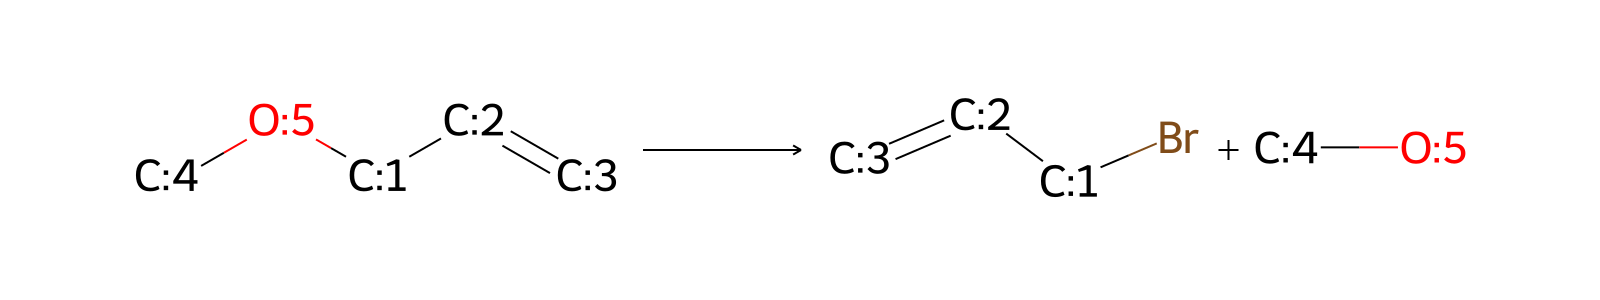

❗ No valid reactants generated.

🔹 Rank 31
TemplateHash: 5e74a6648fc29feb27e7f33b282d335d23b388f0c15a6a4d7f93037be324a77f
Model Probability: 0.20%
SMARTS: [C:7]-[O;H0;D2;+0:8]-[c;H0;D3;+0:1]1:[#7;a:2]:[c:3]:[#7;a:4]:[c:5]:[c:6]:1>>Cl-[c;H0;D3;+0:1]1:[#7;a:2]:[c:3]:[#7;a:4]:[c:5]:[c:6]:1.[C:7]-[OH;D1;+0:8]


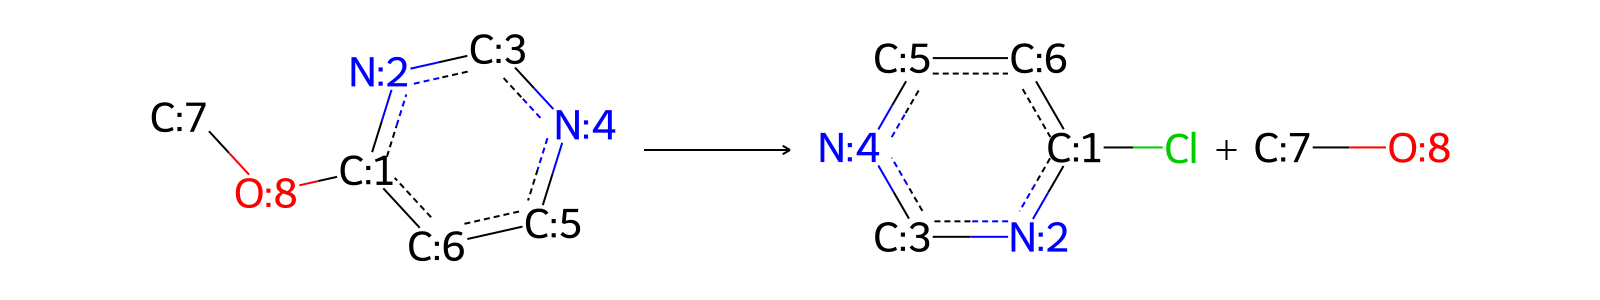

❗ No valid reactants generated.

🔹 Rank 32
TemplateHash: 6e0a0fa35ea74fe6ec010ab2dc1d62f9dc9e7138d23e03eeeefbda3de6c41be3
Model Probability: 0.17%
SMARTS: [O;D1;H0:3]=[C:4]-[O;H0;D2;+0:5]-[CH2;D2;+0:1]-[c:2]>>Br-[CH2;D2;+0:1]-[c:2].[O;D1;H0:3]=[C:4]-[OH;D1;+0:5]


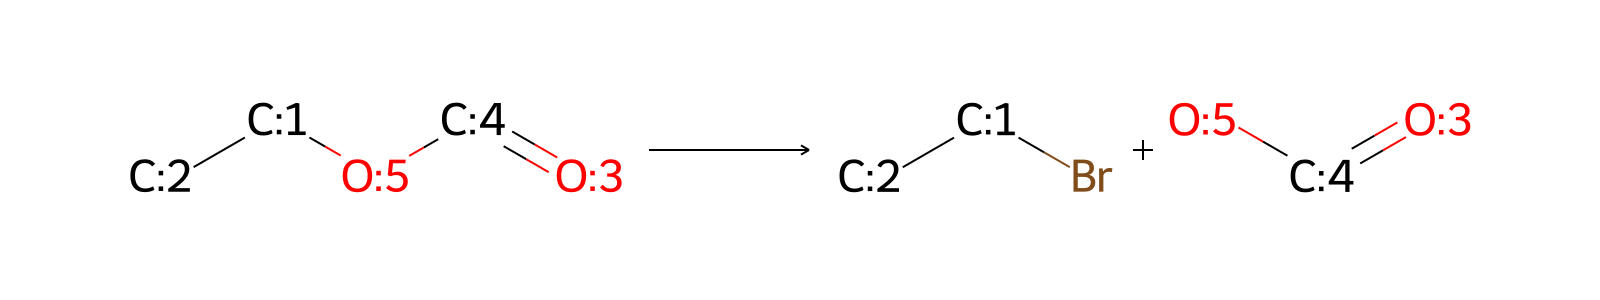

❗ No valid reactants generated.

🔹 Rank 33
TemplateHash: c42f96a0658c03bc12dc20efce06e66daaeccc675d73631eea24ea610a7227b8
Model Probability: 0.16%
SMARTS: [C:2]-[CH2;D2;+0:1]-[O;D1;H1:3]>>O=[C;H0;D3;+0:1](-[C:2])-[O;D1;H1:3]


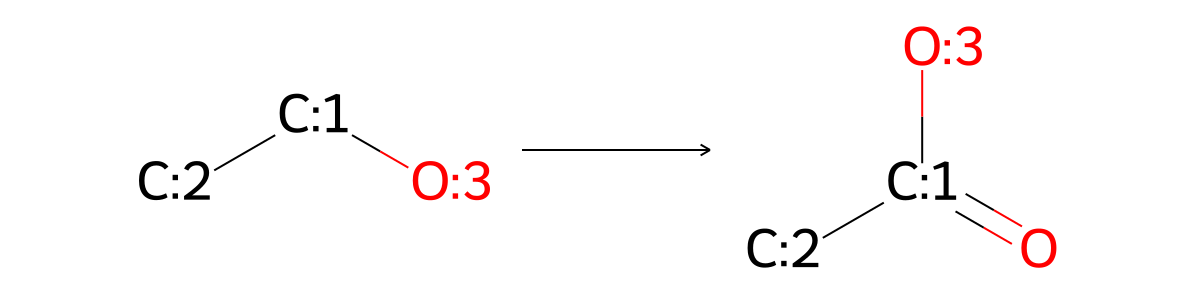

Predicted Reactants:
   ['CCCC(=O)O']

🔹 Rank 34
TemplateHash: 2f0a9b64c8c9ef8d703ed88164912512ff04a6e5a6f9f6e7c038e77b2397968a
Model Probability: 0.16%
SMARTS: [C:3]-[N;H0;D3;+0:4](-[C:5])-[CH2;D2;+0:1]-[c:2]>>Br-[CH2;D2;+0:1]-[c:2].[C:3]-[NH;D2;+0:4]-[C:5]


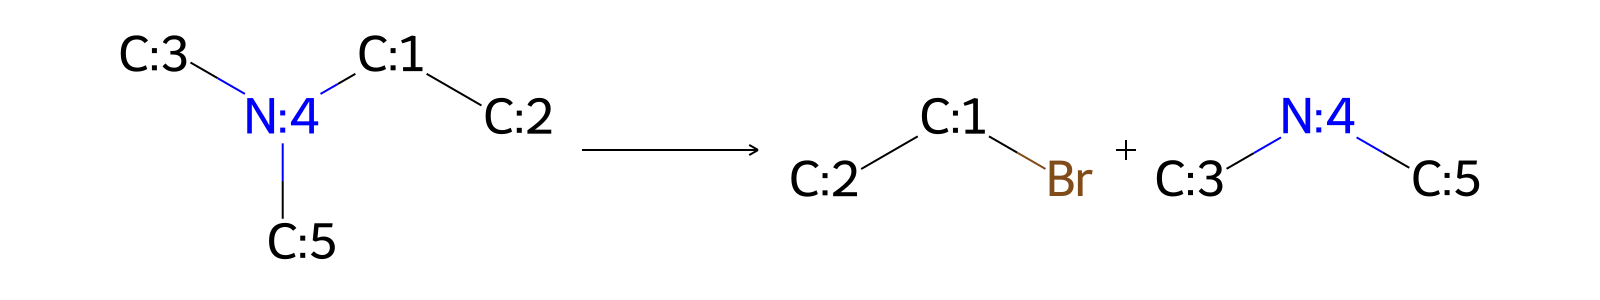

❗ No valid reactants generated.

🔹 Rank 35
TemplateHash: 6c4d56fd6b1e18f68670af0b9b590c9fb9ed8219493d927d4fac41ae9da72f4c
Model Probability: 0.16%
SMARTS: [C:5]-[O;H0;D2;+0:6]-[C;H0;D3;+0:1](=[O;D1;H0:2])-[C:3]=[C;D1;H2:4]>>Cl-[C;H0;D3;+0:1](=[O;D1;H0:2])-[C:3]=[C;D1;H2:4].[C:5]-[OH;D1;+0:6]


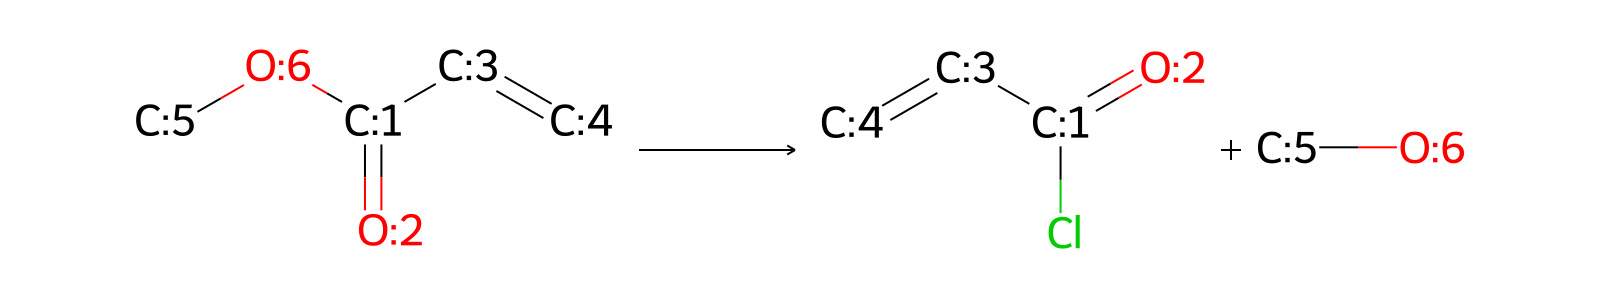

❗ No valid reactants generated.

🔹 Rank 36
TemplateHash: 64e3b0c1b879fbea875d965f87020c94c1011594f717ff161effac99048dbe99
Model Probability: 0.15%
SMARTS: [C:7]-[O;H0;D2;+0:8]-[CH;D3;+0:1]1-[C:2]-[C:3](=[O;D1;H0:4])-[C:5]=[C:6]-1>>Br-[CH;D3;+0:1]1-[C:2]-[C:3](=[O;D1;H0:4])-[C:5]=[C:6]-1.[C:7]-[OH;D1;+0:8]


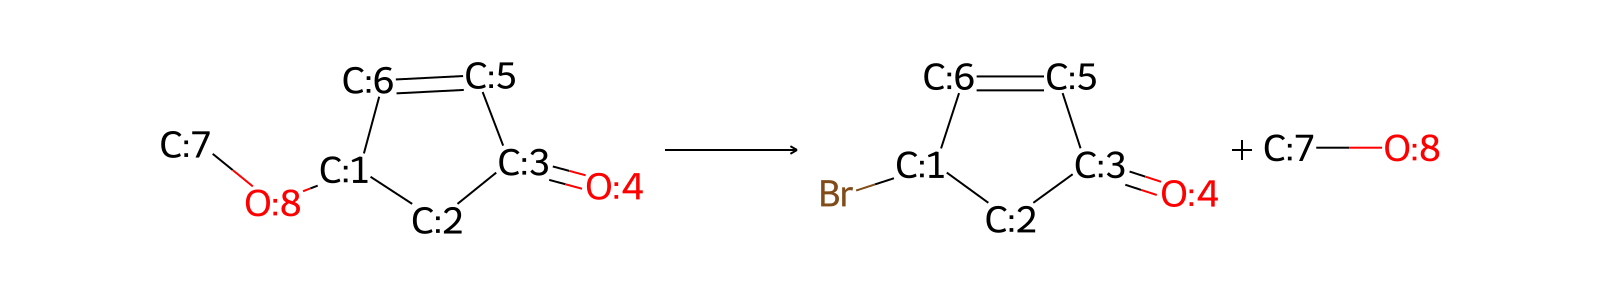

❗ No valid reactants generated.

🔹 Rank 37
TemplateHash: a5630e86678bd2e69b350f0ea6b679f0d956e4ccb45b1ca0fcd985083e1f80a8
Model Probability: 0.13%
SMARTS: [CH2;D2;+0:1]1-[CH2;D2;+0:2]-[O;H0;D2;+0:3]-[CH;D3;+0:4]-[O;H0;D2;+0:5]-1>>O-[CH2;D2;+0:1]-[CH2;D2;+0:2]-[OH;D1;+0:3].[CH;D2;+0:4]=[O;H0;D1;+0:5]


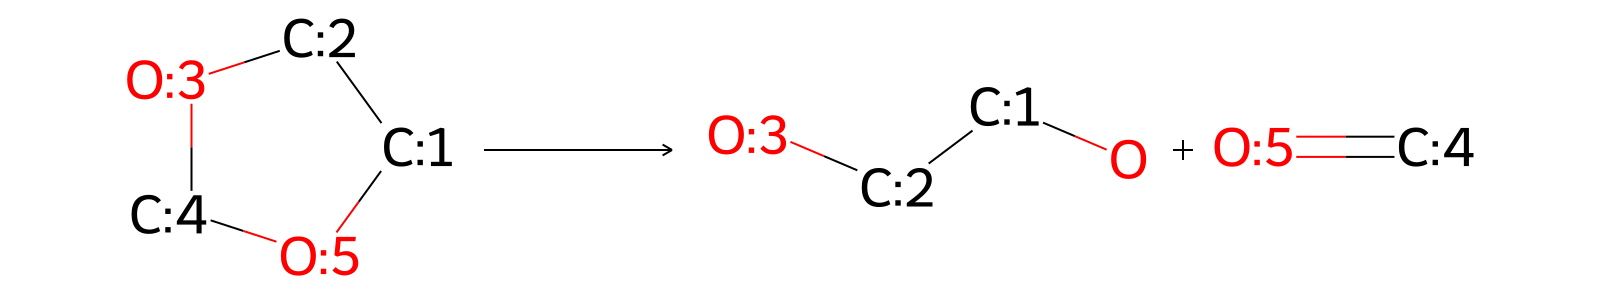

❗ No valid reactants generated.

🔹 Rank 38
TemplateHash: 30d61aee399742b33d420f1273e07eb7ec3a78d2e7efdb35aa364e48a83112bc
Model Probability: 0.13%
SMARTS: [CH2;D2;+0:1]1-[CH2;D2;+0:2]-[CH2;D2;+0:3]-[O;H0;D2;+0:4]-[CH;D3;+0:5]-[O;H0;D2;+0:6]-1>>O-[CH2;D2;+0:1]-[CH2;D2;+0:2]-[CH2;D2;+0:3]-[OH;D1;+0:4].[CH;D2;+0:5]=[O;H0;D1;+0:6]


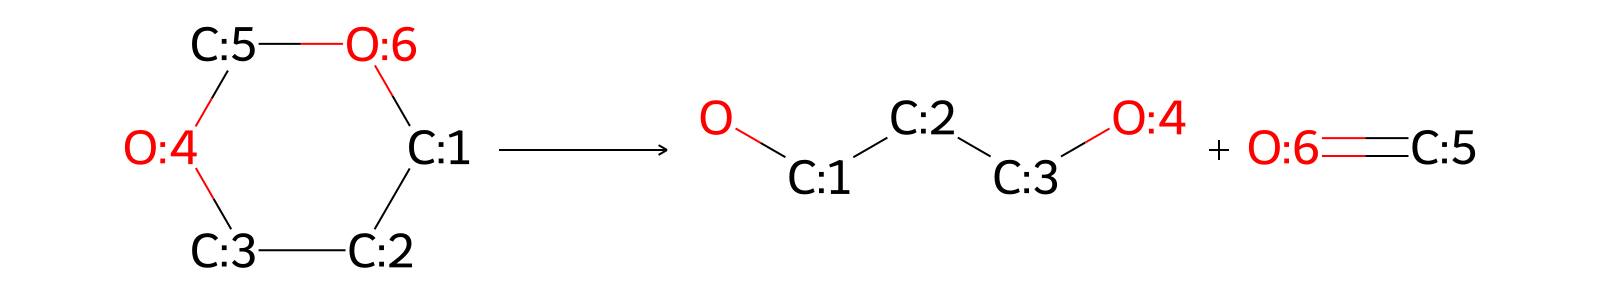

❗ No valid reactants generated.

🔹 Rank 39
TemplateHash: 3db34a90ddea4b3e46b759fbdd17dced79767b76eb07250a1a1a23c23ca3a1c4
Model Probability: 0.11%
SMARTS: [C:12]-[O;H0;D2;+0:13]-[c;H0;D3;+0:1]1:[c:2]:[c:3]:[#7;a:4]:[c:5]:[c:6]:1-[C:7](=[O;D1;H0:8])-[#8:9]-[C:10]-[C;D1;H3:11]>>Cl-[c;H0;D3;+0:1]1:[c:2]:[c:3]:[#7;a:4]:[c:5]:[c:6]:1-[C:7](=[O;D1;H0:8])-[#8:9]-[C:10]-[C;D1;H3:11].[C:12]-[OH;D1;+0:13]


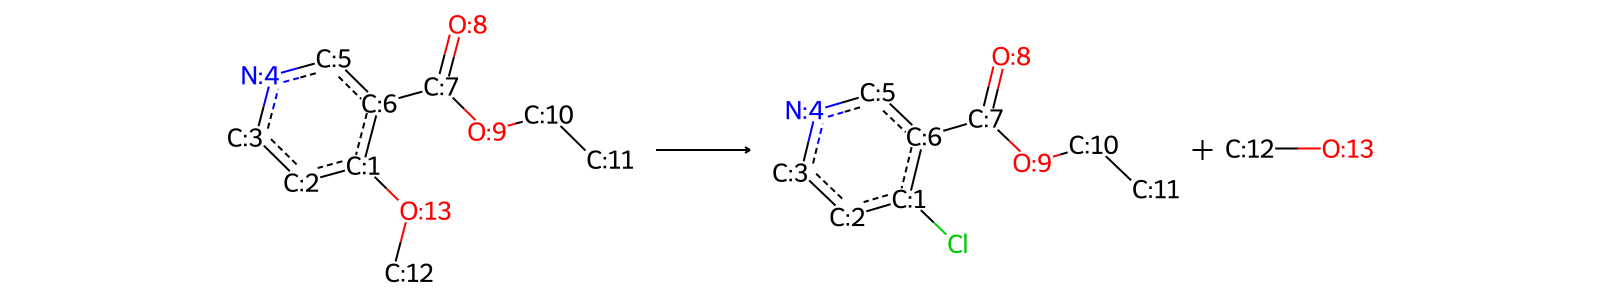

❗ No valid reactants generated.

🔹 Rank 40
TemplateHash: 1d3344734848674bcc6482cab5866a259199e8c6b21cf13573f874222b08172b
Model Probability: 0.11%
SMARTS: [C:7]-[O;H0;D2;+0:8]-[c;H0;D3;+0:1]1:[c:2]:[c:3]:[#7;a:4]:[c:5]:[c:6]:1>>Cl-[c;H0;D3;+0:1]1:[c:2]:[c:3]:[#7;a:4]:[c:5]:[c:6]:1.[C:7]-[OH;D1;+0:8]


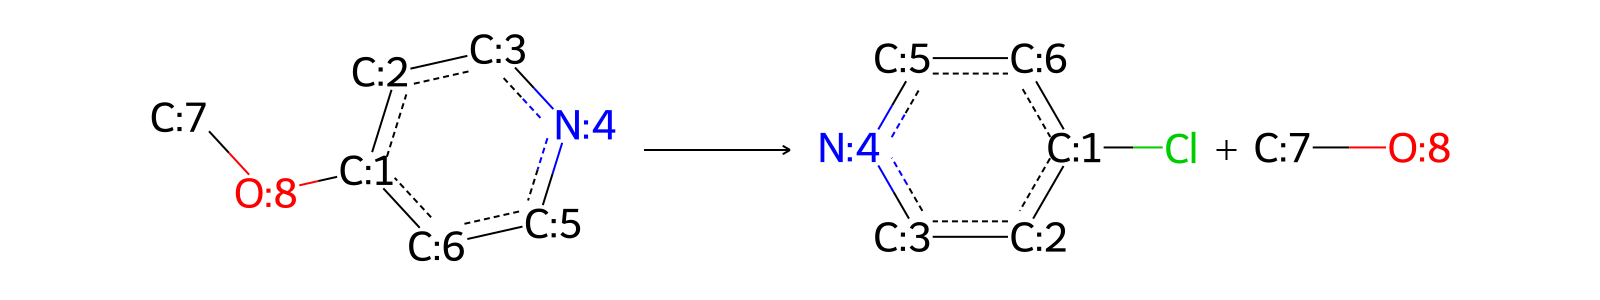

❗ No valid reactants generated.

🔹 Rank 41
TemplateHash: dba4097021b694890c806b10da093797e7718f130551a8c93532ecc87f1de869
Model Probability: 0.11%
SMARTS: [#7;a:4]:[#7;a:3]:[c;H0;D3;+0:1](:[c:2])-[O;H0;D2;+0:6]-[C:5]>>Cl-[c;H0;D3;+0:1](:[c:2]):[#7;a:3]:[#7;a:4].[C:5]-[OH;D1;+0:6]


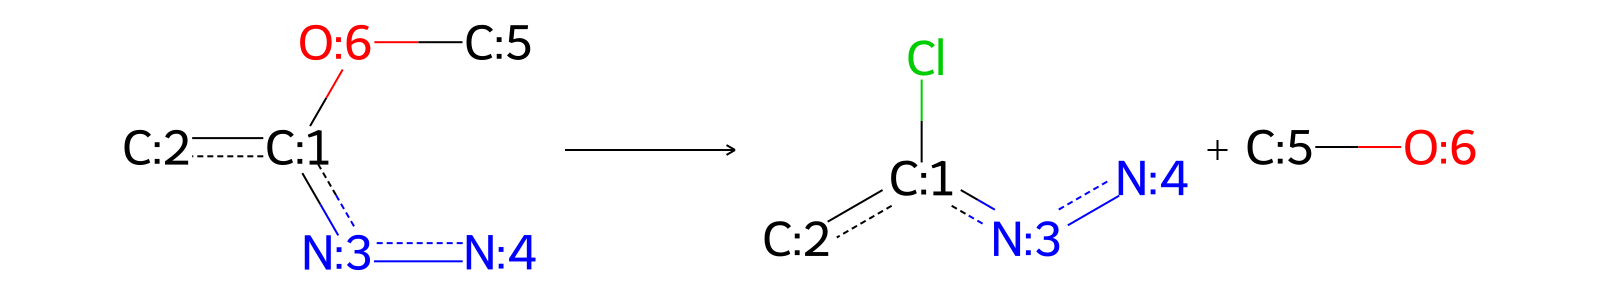

❗ No valid reactants generated.

🔹 Rank 42
TemplateHash: f327e7edf48d6812553280445298b777c242e4acc7e0e9e4afc347576e3a2deb
Model Probability: 0.11%
SMARTS: [C;D1;H3:2]-[CH2;D2;+0:1]-[O;H0;D2;+0:3]-[c:4]>>I-[CH2;D2;+0:1]-[C;D1;H3:2].[OH;D1;+0:3]-[c:4]


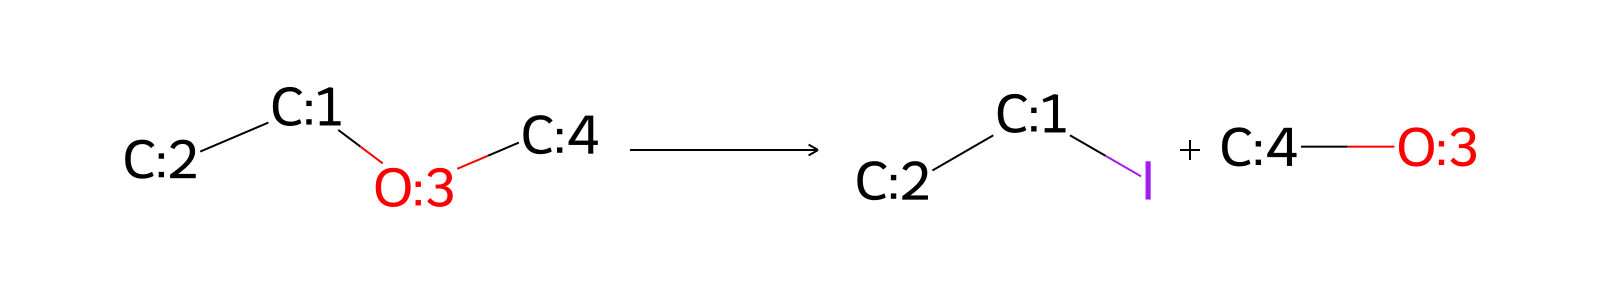

❗ No valid reactants generated.

🔹 Rank 43
TemplateHash: 91866c9bec152b9912ea97804fd0d52ab910c41f54b59fa2def78824da47bad1
Model Probability: 0.11%
SMARTS: [#7;a:4]:[#7;a:3]:[c:2]-[CH2;D2;+0:1]-[O;H0;D2;+0:6]-[C:5]>>Cl-[CH2;D2;+0:1]-[c:2]:[#7;a:3]:[#7;a:4].[C:5]-[OH;D1;+0:6]


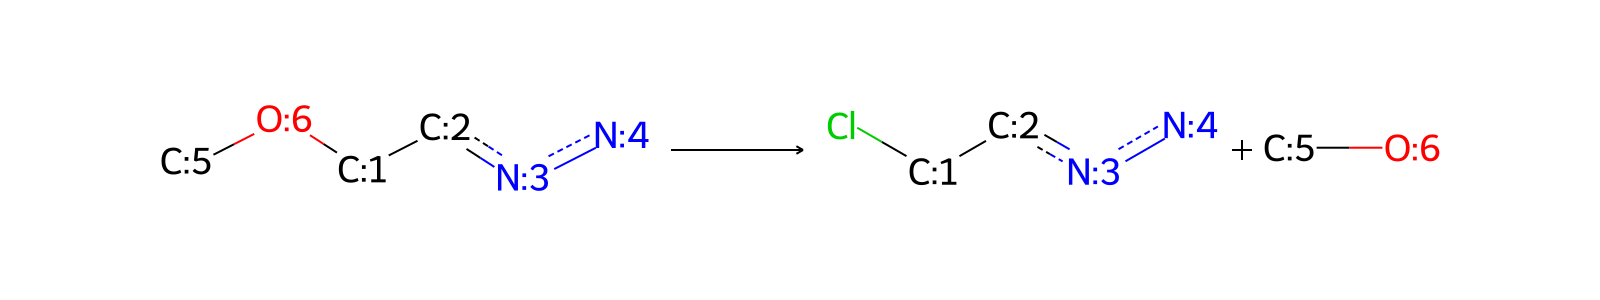

❗ No valid reactants generated.

🔹 Rank 44
TemplateHash: aea9189dcab54cbda1e136907751af9d0de76e364301a68f9b34243d1a3713c9
Model Probability: 0.10%
SMARTS: [#7:3]-[C:4](-[C:6]=[C:7])-[O;H0;D2;+0:5]-[CH2;D2;+0:1]-[C:2]>>O-[CH2;D2;+0:1]-[C:2].[#7:3]-[C:4](-[OH;D1;+0:5])-[C:6]=[C:7]


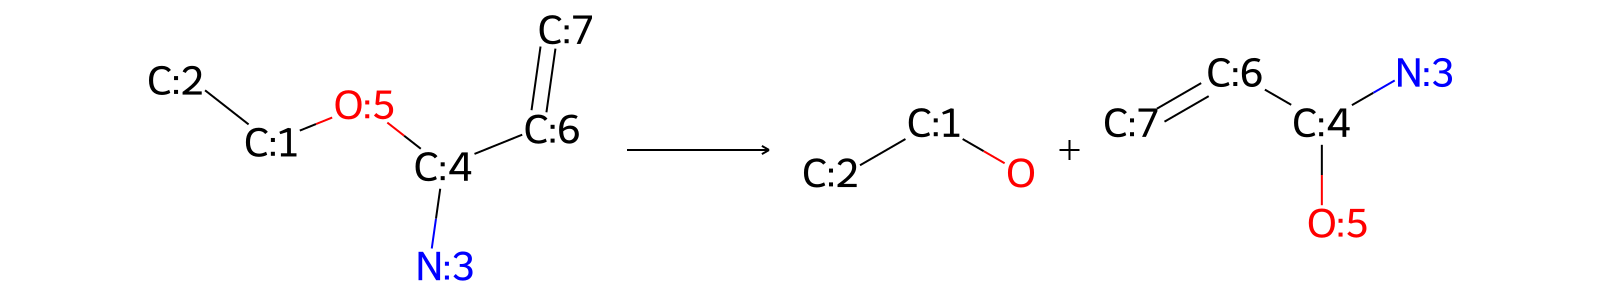

❗ No valid reactants generated.

🔹 Rank 45
TemplateHash: 701a8e651f1a714497ae2849db10b13645a0807a00a14ab35bd9e799424ea026
Model Probability: 0.10%
SMARTS: [C:2]-[CH2;D2;+0:1]-[NH;D2;+0:4]-[C;D1;H3:3]>>O-[CH2;D2;+0:1]-[C:2].[C;D1;H3:3]-[NH2;D1;+0:4]


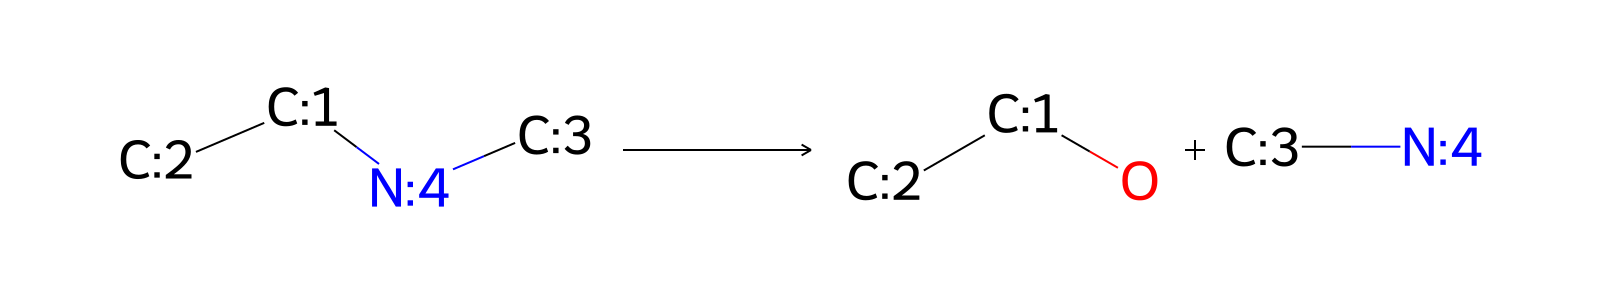

❗ No valid reactants generated.

🔹 Rank 46
TemplateHash: 2aa0e3f275c594703c15ad6eb40308cb7b6213b236a01d538134dc965764722a
Model Probability: 0.08%
SMARTS: [C:1]-[CH;D2;+0:2]=[O;H0;D1;+0:3]>>[C:1]-[CH2;D2;+0:2]-[OH;D1;+0:3]


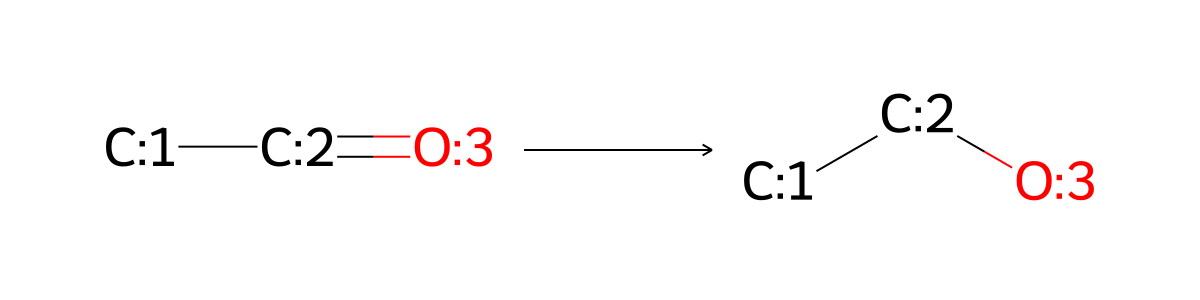

❗ No valid reactants generated.

🔹 Rank 47
TemplateHash: eea03a6c8972042f605eb8eaa596103441c66d8c5a4cd9cd578eef6d20ce6f00
Model Probability: 0.08%
SMARTS: [C:3]-[O;H0;D2;+0:4]-[CH2;D2;+0:1]-[C:2]>>O-[CH2;D2;+0:1]-[C:2].[C:3]-[OH;D1;+0:4]


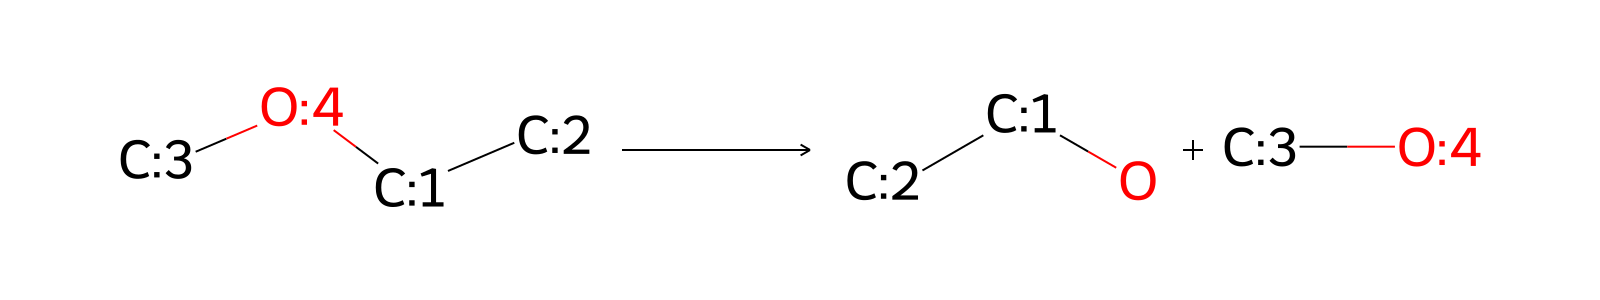

❗ No valid reactants generated.

🔹 Rank 48
TemplateHash: 452650270591e8303734d4f0857dad97b3b23a4b2712ddcc3dac7d88ff99117c
Model Probability: 0.08%
SMARTS: [C:3]-[N;H0;D3;+0:4](-[C:5])-[CH2;D2;+0:1]-[C:2]>>Br-[CH2;D2;+0:1]-[C:2].[C:3]-[NH;D2;+0:4]-[C:5]


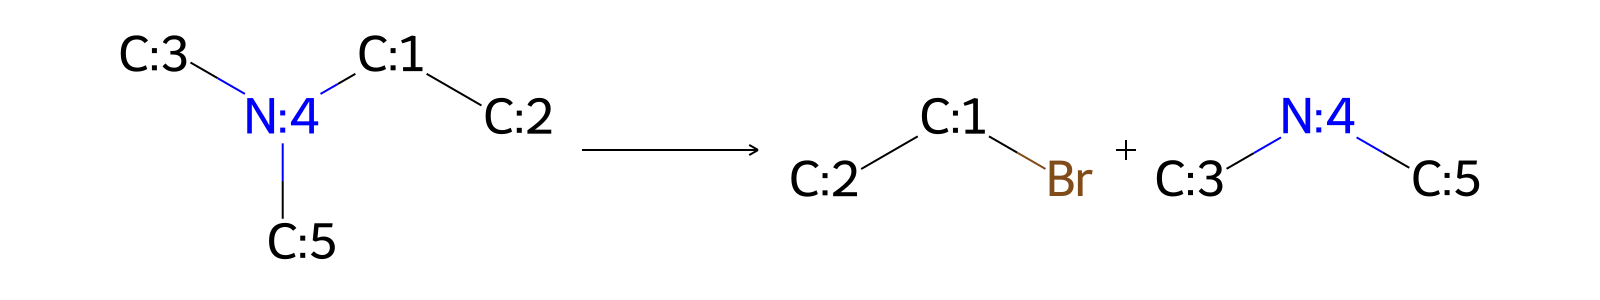

❗ No valid reactants generated.

🔹 Rank 49
TemplateHash: 1d8ec874fd424bafd4174799464dad20ac58b40a4bef4287bb81d31df4b94dfc
Model Probability: 0.08%
SMARTS: [#8:2]-[C;H0;D3;+0:1](=[O;D1;H0:3])-[O;H0;D2;+0:5]-[C:4]>>Cl-[C;H0;D3;+0:1](-[#8:2])=[O;D1;H0:3].[C:4]-[OH;D1;+0:5]


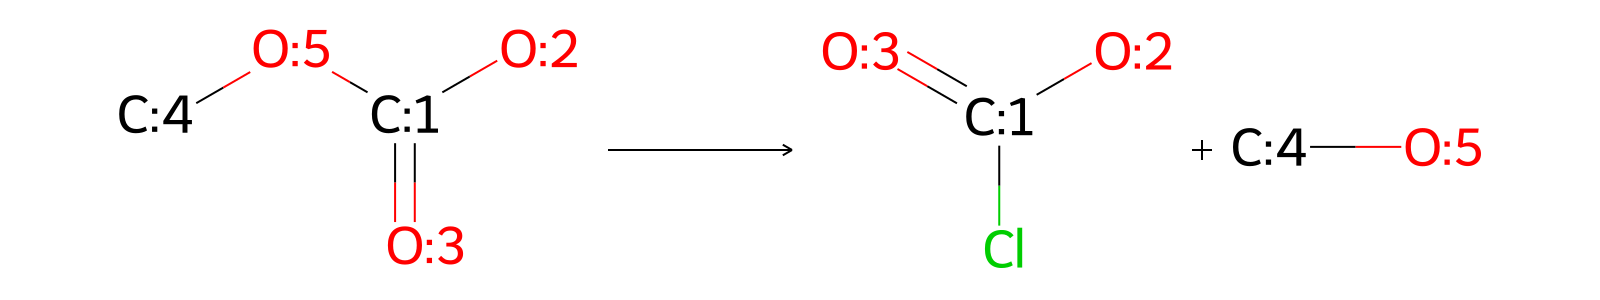

❗ No valid reactants generated.

🔹 Rank 50
TemplateHash: 255db07a19f68597a7cd712c626132bab6594d03ead76a0f7c1566ef5455a336
Model Probability: 0.07%
SMARTS: [C:10]-[O;H0;D2;+0:11]-[c;H0;D3;+0:1]1:[c:2]:[c:3]:[c:4](-[C:5]-[#8:6]-[c:7]):[c:8]:[c:9]:1>>I-[c;H0;D3;+0:1]1:[c:2]:[c:3]:[c:4](-[C:5]-[#8:6]-[c:7]):[c:8]:[c:9]:1.[C:10]-[OH;D1;+0:11]


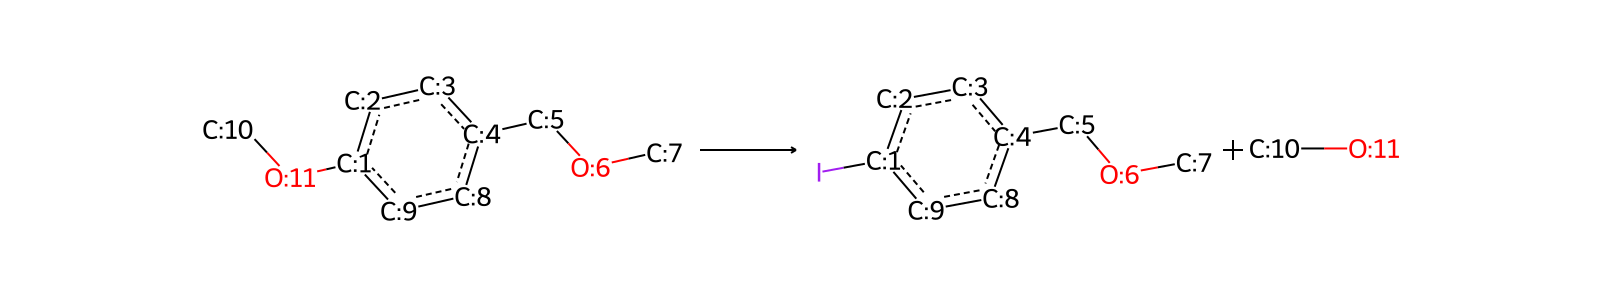

❗ No valid reactants generated.


In [10]:
import joblib
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, rdChemReactions, Draw
from IPython.display import display

# Load model, scaler, label encoder, and template data
model = joblib.load("mlp_classifier_model.pkl")
scaler = joblib.load("scaler.pkl")
label_encoder = joblib.load("label_encoder.pkl")
templates_df = pd.read_csv("/Users/giuliogarotti/Documents/GitHub/Projet_chem/uspto50/uspto50/combined_data.csv", sep="\t")

# Convert a SMILES string to a fingerprint
def smiles_to_fingerprint(smiles, n_bits=2048, radius=2):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return np.array(fp)

# Predict top-k template hashes
def predict_topk_templates(smiles, topk=50):
    fp = smiles_to_fingerprint(smiles)
    fp_scaled = scaler.transform([fp])
    probs = model.predict_proba(fp_scaled)[0]
    topk_indices = np.argsort(probs)[::-1][:topk]
    topk_template_hashes = label_encoder.inverse_transform(model.classes_[topk_indices])
    topk_probs = probs[topk_indices]
    return list(zip(topk_template_hashes, topk_probs))

# Apply a SMARTS reaction to a molecule
def apply_template(smarts, product_smiles):
    mol = Chem.MolFromSmiles(product_smiles)
    try:
        rxn = rdChemReactions.ReactionFromSmarts(smarts)
        results = rxn.RunReactants((mol,))
        return [[Chem.MolToSmiles(m) for m in rset] for rset in results]
    except:
        return []

# --- Main ---
if __name__ == "__main__":
    smiles_input = "CCCCO"

    topk_predictions = predict_topk_templates(smiles_input, topk=50)

    print("\n📋 Top 50 Predicted Templates & Reactants:")
    for rank, (template_hash, prob) in enumerate(topk_predictions, 1):
        row = templates_df[templates_df['TemplateHash'] == template_hash]
        if not row.empty:
            template_smarts = row.iloc[0]['RetroTemplate']
            reactants_sets = apply_template(template_smarts, smiles_input)
            # Create RDKit reaction object
            reaction = rdChemReactions.ReactionFromSmarts(template_smarts)

            # Draw the reaction and display
            img = Draw.ReactionToImage(reaction, subImgSize=(400, 300))

            print(f"\n🔹 Rank {rank}")
            print(f"TemplateHash: {template_hash}")
            print(f"Model Probability: {prob * 100:.2f}%")
            print(f"SMARTS: {template_smarts}")
            display(img)

            if reactants_sets:
                print("Predicted Reactants:")
                for rset in reactants_sets:
                    print(f"   {rset}")
            else:
                print("❗ No valid reactants generated.")
        else:
            print(f"\n🔹 Rank {rank}")
            print(f"TemplateHash: {template_hash}")
            print(f"Model Probability: {prob * 100:.2f}%")
            print("SMARTS: ❓ Not found")



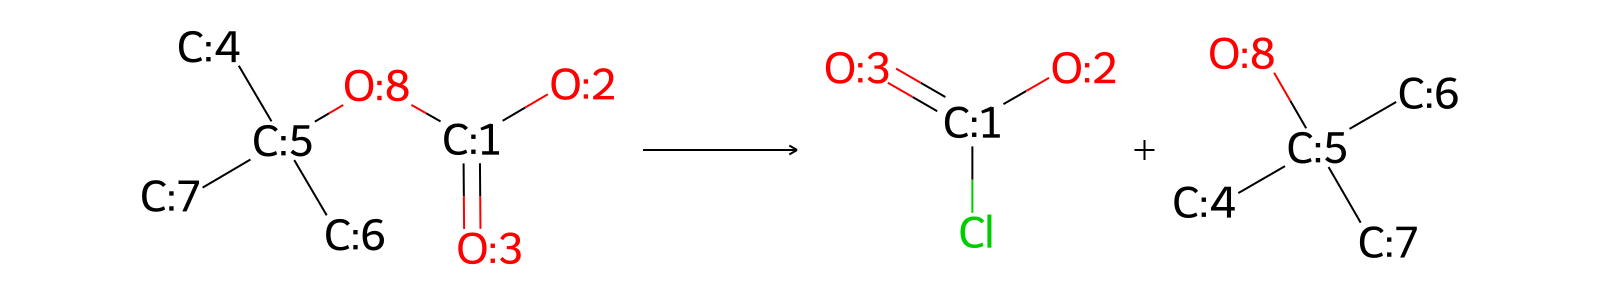

In [7]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem import Draw
from IPython.display import display

# Define the SMARTS reaction
smarts = "[#8:2]-[C;H0;D3;+0:1](=[O;D1;H0:3])-[O;H0;D2;+0:8]-[C:5](-[C;D1;H3:4])(-[C;D1;H3:6])-[C;D1;H3:7]>>Cl-[C;H0;D3;+0:1](-[#8:2])=[O;D1;H0:3].[C;D1;H3:4]-[C:5](-[C;D1;H3:6])(-[C;D1;H3:7])-[OH;D1;+0:8]"

# Create RDKit reaction object
reaction = rdChemReactions.ReactionFromSmarts(smarts)

# Draw the reaction and display
img = Draw.ReactionToImage(reaction, subImgSize=(400, 300))
display(img)




